### 1) import custom functions to prep player data and specify model

In [184]:
from nba_rnn_pkg import utils
from nba_rnn_pkg import model_specification

import numpy as np
import pandas as pd
from datetime import date

---

### 2) pull and filter data from selected season
* **pull_season_data** takes start and end dates from which to pull player stats as arguments. This doesn't have to be a single season if you want to train the model on multiple seasons or a broader era. Currently trains the model on the most recent play-styles (i.e., the current season)
    * NBA seasons generally start in October and end in July, so setting start date as 10/1 and end date as 7/31 for whatever years you're interested in should capture the full season without needing to look up exact start and end dates which vary by season
* **filter_season_data** takes df, minimum # of games played, and minimum # of minutes per game as arguments. These can be toggled based on preference, but the general logic is to exclude benchwarmers
* **add_advanced_stats** unsurprisingly adds advanced stats
    1) True shooting (captures shooting efficiency including free throws; [link](https://en.wikipedia.org/wiki/True_shooting_percentage))
    2) Usage rate (how much of the team's offense goes through each player; [link](https://www.nbastuffer.com/analytics101/usage-rate/))
    3) Game score (John Hollinger's measure of productivity, including most offensive and defensive stats; ([link](https://www.nbastuffer.com/analytics101/game-score/)
    4) Assist-to-turnover ratio (extra measure of playmaking/ball security)
* **clean_master_data** drops some unnecessary columns before setting up model training data

In [294]:
current_season = utils.pull_season_data('2025-10-01', date.today())
filtered = utils.filter_season_data(current_season, 5, 25)
advanced = utils.add_advanced_stats(filtered)
clean_data = utils.clean_master_data(advanced)

In [295]:
clean_data.head()

,personId,playerName,gameId,gameDate,win,home,numMinutes,points,assists,blocks,...,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints,trueShooting,usageRate,gameScore,assistTurnoverRatio
3,1630166,Deni Avdija,22500380,2025-12-18,1,1,42.13,35.0,5.0,0.0,...,4.0,1.0,5.0,2.0,5.0,4.0,0.720758,1.934492,20.4,1.000000
5,1631099,Keegan Murray,22500380,2025-12-18,0,0,42.48,17.0,2.0,4.0,...,2.0,1.0,3.0,3.0,2.0,5.0,0.500000,1.268249,15.7,1.000000
6,1631101,Shaedon Sharpe,22500380,2025-12-18,1,1,35.06,26.0,4.0,0.0,...,3.0,1.0,4.0,2.0,4.0,-7.0,0.568182,2.134050,17.2,1.000000
13,1641739,Toumani Camara,22500380,2025-12-18,1,1,34.37,17.0,5.0,0.0,...,6.0,2.0,8.0,6.0,2.0,13.0,0.659938,1.205066,15.5,2.500000
20,201566,Russell Westbrook,22500380,2025-12-18,0,0,35.25,20.0,10.0,0.0,...,3.0,0.0,3.0,4.0,3.0,2.0,0.783699,1.267747,17.7,3.333333


---

### 3) format the training data
* first, decide what we want the RNN to predict (many-to-many). Here, we include stats which are independent of each other to avoid collinearity (i.e., don't predict both FGA and true shooting at the same time)
* before scaling continuous measures, make sure win (1 = win, 0 = loss) and home (1 = home game, 0 = away game) remain binary (0.4 for home is uninterpretable)
    * notably, when we try to predict 'win' we treat it continuously such that it is essentially a probability measure (i.e., 0.8 for win reflects model predicting an 80% chance of win). This is obviously a bit simplified and if the primary goal was prediction rather than representation, we might use more complex logic which makes a binary choice. Here, this is sufficient to learn and represent play styles
* second, we decide what stats the RNN can use to predict its targets. Here we try to avoid predictors which are obviously duplicative (e.g., using true shooting as our efficiency rating instead of FG%), even though some measures will covary somewhat (e.g., FGA and points)
* **prepare_rnn_dataframe** takes the targets and features we've defined and creates prediction columns for the RNN (e.g,. NEXT game), dropping the final game of the season for which there is no next game
* **create_3d_arrays** groups by player so the RNN sees sequential data and pads players missing games with zeros so that data inputted for each player is the same shape/length. When instantiating the model, we use masking to make sure these zero columns aren't actually used for prediciton

In [296]:
rnn_data = clean_data.copy()

target_cols = ['win', 'points', 'assists', 'reboundsOffensive', 'reboundsDefensive', 'steals', 'blocks']
metadata_cols = ['personId', 'gameId', 'gameDate' 'firstName', 'lastName']
binary_cols = ['win', 'home']

# our efficiency rating is trueShooting rather than FG%
feature_cols = [
    'numMinutes', 'usageRate', 'fieldGoalsAttempted', 'threePointersAttempted', 
    'freeThrowsAttempted', 'points', 'assists', 'reboundsOffensive', 
    'reboundsDefensive', 'steals', 'blocks', 'turnovers', 'home',
    'trueShooting', 'gameScore', 'plusMinusPoints'
]

# execute scaling and generate targets
processed_df, x_scaler, y_scaler, final_target_cols = model_specification.prepare_rnn_dataframe(
    rnn_data, feature_cols, target_cols, binary_cols, metadata_cols
)

print(f"Original rows: {len(rnn_data)}")
print(f"Processed rows (after dropping most recent games w/ no targets): {len(processed_df)}")
print(f"Target columns created for: {target_cols}")

# set up 3D data for training; player x game x feature; pad players with fewer games with 0's
X_train, Y_train, player_order = model_specification.create_3d_arrays(
    processed_df, feature_cols, binary_cols, final_target_cols
)

print()
print(f"X_train Shape (# players, max # games, # predictive features): {X_train.shape}") # (num Players, num Max_Games, num features 18)
print(f"Y_train Shape: (# players, max # games, # targets): {Y_train.shape}") # (Players, Max_Games, 5)

Original rows: 4256
Processed rows (after dropping most recent games w/ no targets): 4092
Target columns created for: ['win', 'points', 'assists', 'reboundsOffensive', 'reboundsDefensive', 'steals', 'blocks']

X_train Shape (# players, max # games, # predictive features): (164, 32, 18)
Y_train Shape: (# players, max # games, # targets): (164, 32, 7)


---

### 4) initialize the RNN
* Here, we construct the actual model. By having the RNN iteratively predict future production/wins from sequences of games within a season, we are essentially making the RNN learn high-dimensionsal statisical 'styles' for each player and how they translate to success. We can then directly examine what the RNN learned about play styles to identify consistent styles across the league, group players by style, assess what styles are most conducive to success, and identify players across eras with similar play styles.
* In that sense, it doesn't actually matter if the model can super accurately predict future wins - we would probably have the same success predicting wins with OLS regression (or flipping a coin). The reason an RNN is interesting and meaningful here is because we can use it actually assess what the model learned (the hidden state/'ball knowledge'). The value of an RNN (in my opinion) is not in the result, it's in the representation.
* Model is organized as follows:
    1) Input layer - pass in the game-by-game stats we curated for each player
    2) Masking layer - ignore zeroes added to pad players with missing games (don't update knowledge state based on missing data)
    3) LSTM Layer (128 units; ~ 6 times imput feature count); return_sequences allows us to extract style vectors for every game, not just the last one. The 'style_vector_layer' becomes what the model learns about each player's style
    4) Dropout for regularization (prevents overfitting to specific players); essentially turns off 20% of units so that model doesn't over-fixate on memorizing specific players
    5) Output layer - Predicts win_prob, pts, ast, orb, drb, stl, blk for every game in the sequence
          * linear activation becuase we're predicting continuous numbers (even win since we're treating it as continuous, i.e., p(win))
          * standard optimizer and loss function - adaptive moment estimation (adam) allows for different learning rates for each parameter

In [297]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Dropout

def build_style_rnn(n_timesteps, n_features, n_outputs): 
    inputs = Input(shape=(n_timesteps, n_features))
    masked = Masking(mask_value=0.0)(inputs)

    lstm_out = LSTM(128, return_sequences=True, name='style_vector_layer')(masked)
    dropped = Dropout(0.2)(lstm_out)

    outputs = Dense(n_outputs, activation='linear')(dropped)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    
    return model

print(f'initializing model with {X_train.shape[1]} timesteps, {X_train.shape[2]} features, {Y_train.shape[2]} targets')
model = build_style_rnn(X_train.shape[1], X_train.shape[2], Y_train.shape[2])
model.summary()

initializing model with 32 timesteps, 18 features, 7 targets


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 32, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_11        │ (None, 32, 18)    │          0 │ input_layer_11[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_11          │ (None, 32, 18)    │          0 │ input_layer_11[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_11 (Any)        │ (None, 32)        │          0 │ not_equal_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ style_vector_layer  │ (None, 32, 128)   │     75,264 │ masking_11[0][0], │
│ (LSTM)              │                   │            │ any_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 128)   │          0 │ style_vector_lay… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32, 7)     │        903 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,167 (297.53 KB)

 Trainable params: 76,167 (297.53 KB)

 Non-trainable params: 0 (0.00 B)

### Layers:
1) input layer - output stats to masking layers 
2) mask layer - avoid learning from padded zeroes
3) LSTM layer (style_vector_layer) - the brain; 75,776 parameters = 4 internal gaes (forget, input, candidate, output) x 128 units x (128 units + 19 inputs + 1)
4) droupout later - shuts off units during training to avoid overfit
5) dense output - condenses 128 unit dimensions back into seven target variables

---

### 5.1) Train the model
* fill nan's with zeros - there should be very few in the training data but division by zero is possible for measures like trueShooting
* standard adam optimization (see above) with slightly slower learning rate because basketball data is noisy
* clipnorm stops model from over-correcting when encountering extreme values during gradient descent (think Terrence Ross's random 50 point game; we don't want the model coming across that and thinking he became a superstar overnight)
* 50 epochs - validation loss doesn't really move after epoch 10 so 50 seems more than sufficient
* 32 batch size - hardware handles data in multiples of 32, also roughly two NBA roster worth of players

In [302]:
from tensorflow.keras.optimizers import Adam

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
model = build_style_rnn(X_train.shape[1], X_train.shape[2], Y_train.shape[2])

# slightly slower learning rate becuas basketball data is noisy; clipnorm stops model from over correcting during gradient descent
opt = Adam(learning_rate=0.0005, clipnorm=1.0) 
model.compile(optimizer=opt, loss='mse')

history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.0242 - val_loss: 0.8404
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9256 - val_loss: 0.7937
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8608 - val_loss: 0.7609
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7872 - val_loss: 0.7406
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7744 - val_loss: 0.7277
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7803 - val_loss: 0.7187
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7483 - val_loss: 0.7112
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7534 - val_loss: 0.7058
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7410 - val_loss: 0.7021
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7451 - val_loss: 0.7001
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7557 - val_loss: 0.6988
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7299 - val_loss: 0.6972
E

### 5.2) extract the learned weights from the LSTM layer
* skip dense layer so we maintain the 128-dimensional 'ball knowledge' hidden state
* for each player, extract how the model represents their play style from the FINAL game of the season (the model's cumulative knowledge, derived across all included games)

In [303]:
# create a model that outputs the result of the LSTM layer (skipping dense layer); essentially extracts learned weights 
# of model without condensing back into target variables (128-dimensional hidden state)
style_extractor = Model(inputs=model.input, 
                         outputs=model.get_layer('style_vector_layer').output)

# for each player, extract play style from hidden state
all_style_sequences = style_extractor.predict(X_train)

# take the FINAL game's state (the cumulative memory of the whole season)
final_style_vectors = all_style_sequences[:, -1, :]

print(f"Style Vector Shape (players x units): {final_style_vectors.shape}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Style Vector Shape (players x units): (164, 128)


---

### 6. evaluate the predictability of the model
* while prediction is a secondary focus relative to exploring underlying representaitons, we do want to make sure our model is learning
* **Is our model predicting wins?** - kind of! if we treat 'predicting a win' as p(win) > 0.5 and look at how often those predictions are correct, our model is more accurate than chance. While ~60% accuracy is probably not enough to put the house on the next game, it's impressive accuracy given the random and complex nature of winning NBA games
* **Is our model predicting player performance?** - yes! On average, we're predicting scoring within 1 point per game. Again, this does not mean our model will generalize perfectly to future games (modeling historical data is not the same as predicting future outcomes!), but it definitely suggests our model effectively learned about our players

In [306]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error

# get model predictions
y_pred = model.predict(X_train)

# padding mask using input features; make sure we're assessing timesteps where any feature !=0 (i.e., real games)
mask = np.any(X_train != 0, axis=-1).flatten()

# predict wins (index 0)
y_true_win = Y_train[:, :, 0].flatten()[mask]
y_pred_win = y_pred[:, :, 0].flatten()[mask]

# convert probabilities to binary predictions
y_true_binary = y_true_win.astype(int)
y_pred_binary = (y_pred_win > 0.5).astype(int)

win_accuracy = accuracy_score(y_true_binary, y_pred_binary)

print(f"Win Accuracy: {win_accuracy * 100:.2f}%")

# predict points (index 1)
y_true_pts = Y_train[:, :, 1].flatten()[mask]
y_pred_pts = y_pred[:, :, 1].flatten()[mask]

points_mae = mean_absolute_error(y_true_pts, y_pred_pts)

print(f"Points MAE: {points_mae:.2f} points per game")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Win Accuracy: 59.90%
Points MAE: 0.64 points per game


---

### 7) Identify player archetypes from the model's 128-dimensional 'ball knowledge' hidden state
* I'm pre-determining that I want my model to come up with 9 archetypes. This is a somewhat arbitrary choice that I'm making because I think it provides an interpretable number of groupings, as over-clustering (e.g., 20+ archetypes) or under-clustering (e.g., 2 archetypes) will not produce meaningful groupings. That being said, using an elbow method or silhoutte score approach suggests that using anywhere from 6-12 clusters will provide similar disciminability between clusters.
* Note: if re-initializing the model and running again, clusters should be very similar (i.e., similar players grouped together) but will not necessarily be in the same order. The names I gave each cluster will not necessary line up correctly if re-run, and would need to be re-mapped

In [343]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

vis_df = pd.DataFrame({
    'personId': player_order # we generated this above when we created the training data
})
# reduce 128D -> 3D for visualization
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=77)
dims_3d = tsne_3d.fit_transform(final_style_vectors)

vis_df['x'] = dims_3d[:, 0]
vis_df['y'] = dims_3d[:, 1]
vis_df['z'] = dims_3d[:, 2]

n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=77, n_init=10)

# use the 128D vectors extracted from the hidden state directly for clustering to make sure we use the model's full 'brain'
cluster_labels = kmeans.fit_predict(final_style_vectors)
vis_df['cluster'] = cluster_labels
# map player names to their unique IDs
name_lookup = rnn_data[['personId', 'playerName']].drop_duplicates(subset='personId')
vis_df = pd.merge(vis_df, name_lookup, on = 'personId', how = 'inner')

# merge clusters back to master (unscaled) game-level data
profile_df = pd.merge(rnn_data, vis_df, on='personId')
# define profile metrics we want to see
profile_metrics = ['win', 'points', 'assists', 'reboundsOffensive', 'reboundsDefensive', 'steals', 'blocks']
# calculate 'centroids' - the average stat line for each clustered style
cluster_profiles = profile_df.groupby('cluster')[profile_metrics].mean()
cluster_profiles = cluster_profiles.sort_values(by='points', ascending=False)


In [335]:
def get_cluster_representatives(df, cluster_id, num_players=5):
    players = df[df['cluster'] == cluster_id]['personId'].unique()
    return list(players[:num_players])

for i in range(n_clusters):
    reps = get_cluster_representatives(profile_df, i)
    cluster_names = []
    
    for rep in reps:
        # Get first and last name
        p_data = rnn_data[rnn_data['personId'] == rep]
        full_name = p_data['playerName'].values[0]
        cluster_names.append(full_name)
    
    print(f"\n--- Cluster {i} Archetypes ---")
    print(", ".join(cluster_names))


--- Cluster 0 Archetypes ---
Russell Westbrook, Dennis Schroder, Collin Gillespie, LeBron James, De'Aaron Fox

--- Cluster 1 Archetypes ---
Shaedon Sharpe, Jerami Grant, Dillon Brooks, Desmond Bane, Paolo Banchero

--- Cluster 2 Archetypes ---
DeMar DeRozan, Brandin Podziemski, Jimmy Butler III, Zion Williamson, Jalen Williams

--- Cluster 3 Archetypes ---
Jalen Duren, Ausar Thompson, Jakob Poeltl, Ivica Zubac, Chet Holmgren

--- Cluster 4 Archetypes ---
Toumani Camara, Royce O'Neale, Wendell Carter Jr., Anthony Black, Draymond Green

--- Cluster 5 Archetypes ---
Deni Avdija, Devin Booker, Jamal Murray, Luka Doncic, Keyonte George

--- Cluster 6 Archetypes ---
Nikola Jokic, Alperen Sengun, Amen Thompson, Stephon Castle, Jalen Johnson

--- Cluster 7 Archetypes ---
Rui Hachimura, Cameron Johnson, Marcus Smart, Duncan Robinson, Naji Marshall

--- Cluster 8 Archetypes ---
Keegan Murray, P.J. Washington, Anthony Davis, Scottie Barnes, Victor Wembanyama


---

### 8) Examining derived archetypes
Clustering gives us some really fascinating archetypal play styles. Based on the players sorted into each archetype, I've given each cluster a name below. Some fascinating notes based on archetypes alone:
* Jokic and Sengun are clustered with pass-first guards like Stephon Castle and Jalen Johnson; despite being 7-footers, their passing prowess places them in the dynamic play-maker cluster
* Amen Thompson ends up in a defensive bruiser category with bigs like Jalen Duren, Zubac, and Holmgren. He's a guard playing much bigger than his height 
* Deni Avdija and Keyonte George in the offensive engines category - both are having fantastic years despite being on middling teams

Notably, these are just archetypes based on centroid stats. A lot of superstar players may fit in multiple categories due to their versatility. I highlight a few of those specifically below, and their positions in feature space are really fascinating:

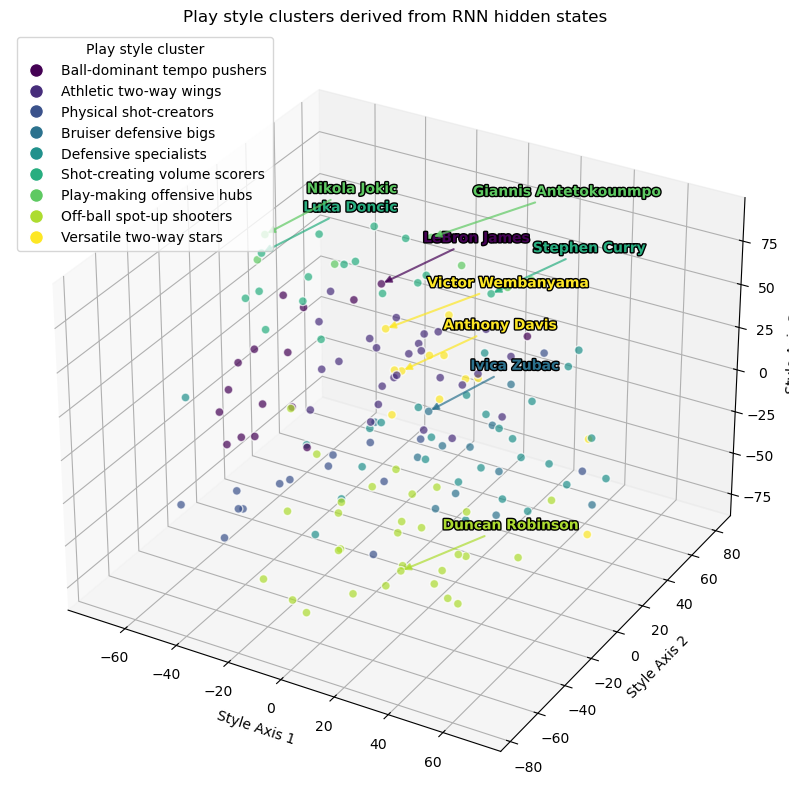

In [522]:
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.lines import Line2D
import numpy as np

players_to_annotate = [
    'LeBron James', 'Stephen Curry', 'Giannis Antetokounmpo', 'Duncan Robinson',
    'Luka Doncic', 'Victor Wembanyama', 'Anthony Davis', 'Nikola Jokic', 'Ivica Zubac']

cluster_labels = {
    0: "Ball-dominant tempo pushers",
    1: "Athletic two-way wings",
    2: "Physical shot-creators",
    3: "Bruiser defensive bigs",
    4: "Defensive specialists",
    5: "Shot-creating volume scorers",
    6: "Play-making offensive hubs",
    7: "Off-ball spot-up shooters",
    8: "Versatile two-way stars"}

clusters = np.sort(vis_df['cluster'].unique())
n_clusters = len(clusters)
cmap = plt.get_cmap('viridis', n_clusters)
cluster_colors = {c: cmap(i) for i, c in enumerate(clusters)}

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    vis_df['x'], vis_df['y'], vis_df['z'],
    c=vis_df['cluster'].map(cluster_colors),
    s=40,
    alpha=0.7,
    edgecolors='w')

for player_name in players_to_annotate:
    player_row = vis_df[vis_df['playerName'] == player_name].iloc[0]
    x, y, z = player_row['x'], player_row['y'], player_row['z']
    cluster_id = player_row['cluster']
    x2, y2, _ = proj3d.proj_transform(x, y, z, ax.get_proj())

    # annotate some star players
    ax.annotate(
        player_name,
        xy=(x2, y2),
        xytext=(30, 30),
        textcoords='offset points',
        color=cluster_colors[cluster_id],
        weight='bold',
        path_effects=[patheffects.withStroke(linewidth=2, foreground='black')],
        arrowprops=dict(
            arrowstyle='-|>',
            color=cluster_colors[cluster_id],
            lw=1.5,
            alpha=0.7))

# create legend with custom cluster labels
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=cluster_labels.get(c, f"Cluster {c}"),
        markerfacecolor=cluster_colors[c],
        markersize=10) for c in clusters]

ax.legend(
    handles=legend_elements,
    title="Play style cluster",
    loc="upper left",
    frameon=True)

ax.set_title("Play style clusters derived from RNN hidden states")
ax.set_xlabel("Style Axis 1")
ax.set_ylabel("Style Axis 2")
ax.set_zlabel("Style Axis 3")

plt.show()


A lot of interesting stuff going on here!
* Jokic is much closer in play-style space to Luka than he is to AD or Wemby despite all being centers. This is one of the most interesting parts of modeling performance completely agnostic of position, height, or weight and suggests we are accurately capturing play-style
* Lebron and Wemby are much more central, consistent with their high-volume do-it-all play styles
* Luka and Steph are less centrally embedded, consistent with their scoring-focused play styles, while neither is thought of as an elite defender, rebounder, etc.
* Wemby is embedded between LeBron and AD - to me this is really similar to how I'd describe his play-style; while he can rim-run and block shots like AD, he also handles the ball and creates his own shot from the perimeter like LeBron
* Giannis is classified as a play-making offensive hub, but is also embedded within the shot-creating volume scorers, consistent with both high usage and high efficiency
* Highly-specialized players like Duncan Robinson, Ivica Zubac, tend toward the edges of different axes

---

### 9) Direct unit interrogation: what units are most predictive of wins, and what are those units actually tracking

In [408]:
# get weights from the final output layer
output_layer = model.layers[-1]
weights, biases = output_layer.get_weights()

# extract weights specifically for win target (index 0)
win_weights = weights[:, 0]

# find the largest absolute values (either correlated or anti-correlated w/ wins)
top_unit_indices = np.argsort(np.abs(win_weights))[::-1][:5]

print("Top 5 Hidden Units most predictive of Wins:")
for idx in top_unit_indices:
    influence = "Increases Win Prob" if win_weights[idx] > 0 else "Decreases Win Prob"
    print(f"Unit #{idx}: Weight {win_weights[idx]:.4f} ({influence})")

Top 5 Hidden Units most predictive of Wins:
Unit #27: Weight 0.2073 (Increases Win Prob)
Unit #99: Weight 0.2034 (Increases Win Prob)
Unit #69: Weight 0.1975 (Increases Win Prob)
Unit #31: Weight 0.1940 (Increases Win Prob)
Unit #90: Weight -0.1929 (Decreases Win Prob)


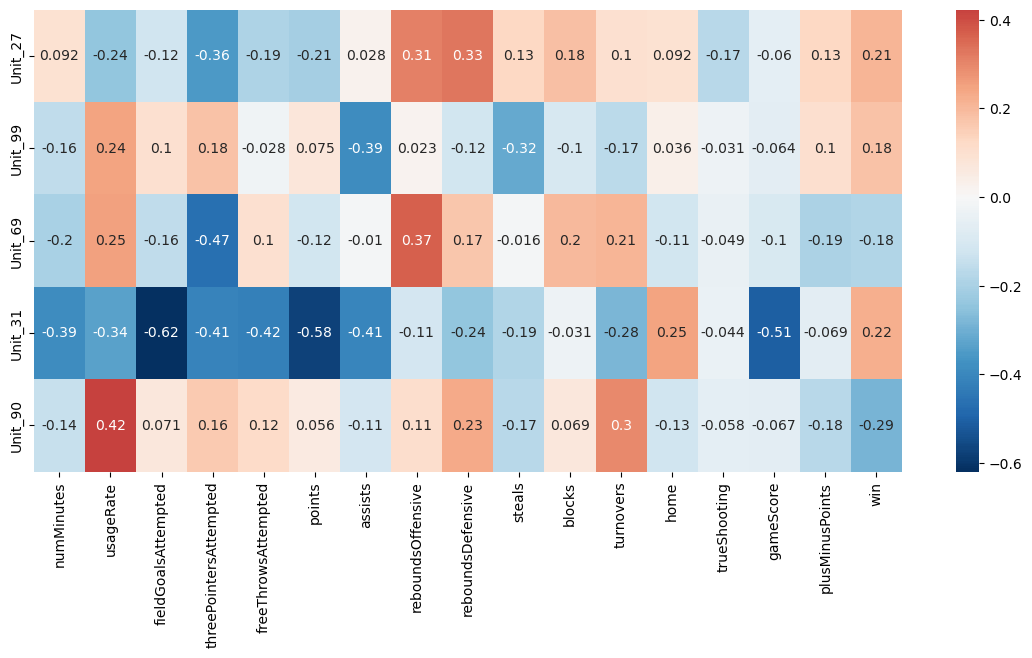

In [410]:
import seaborn as sns
all_features_flat = X_train.reshape(-1, X_train.shape[2])
all_hidden_flat = all_style_sequences.reshape(-1, 128)
top_units_data = all_hidden_flat[:, top_unit_indices]

raw_feature_names = feature_cols + binary_cols
feat_df = pd.DataFrame(all_features_flat, columns=raw_feature_names)

# remove duplicate columns
feat_df = feat_df.loc[:, ~feat_df.columns.duplicated()]

# set up correlation df
corr_df = pd.DataFrame(top_units_data, columns=[f"Unit_{i}" for i in top_unit_indices])
full_corr = pd.concat([corr_df, feat_df], axis=1).corr()

# pull feature names
final_feature_names = feat_df.columns.tolist()
unit_feature_corr = full_corr.loc[[f"Unit_{i}" for i in top_unit_indices], final_feature_names]

plt.figure(figsize=(14, 6))
sns.heatmap(unit_feature_corr, annot=True, cmap='RdBu_r', center=0)
plt.show()

Several units are tracking performance, and interestingly do reflect some specialization!
* Unit 27 and Unit 69 = the rebounders (heavily weights ORB and DRB)
    * Unit 69 also negatively weights 3PA, further suggesting they may be tracking rim-running rebound specialists
* Unit 99 = the spot-up shooter (heavily weights usage rate, 3PA, negatively weights assists)
* Unit 31 = the empty calories scorer (negatively weights FGA, points, gameScore), suggests good stats don't always lead to wins (think Deni Avdija and the Wizards)
* Unit 90 = the workhorse (heavily weights usageRate, rebounds, and turnovers)
* What's especially fascintating is that these win-predictive units really are not tracking points, suggesting the players driving wins are more versatile than pure scorers

---

### 10) Direct unit interrogation; what types of shots do our 'scoring' units track?

In [423]:
# pull weights from the final output layer
weights, _ = model.layers[-1].get_weights()

# extract weights specifically for 'Points' (index 1)
points_weights = weights[:, 1]

# top 5 units that predict high scoring
top_scoring_units = np.argsort(np.abs(points_weights))[::-1][:5]

print("Top 5 Hidden Units most predictive of Total Points:")
for idx in top_scoring_units:
    direction = "High Points" if points_weights[idx] > 0 else "Low Points"
    print(f"Unit #{idx}: Weight {points_weights[idx]:.4f} ({direction})")

Top 5 Hidden Units most predictive of Total Points:
Unit #33: Weight 0.2117 (High Points)
Unit #103: Weight 0.2094 (High Points)
Unit #52: Weight 0.2087 (High Points)
Unit #41: Weight 0.2085 (High Points)
Unit #20: Weight -0.2005 (Low Points)


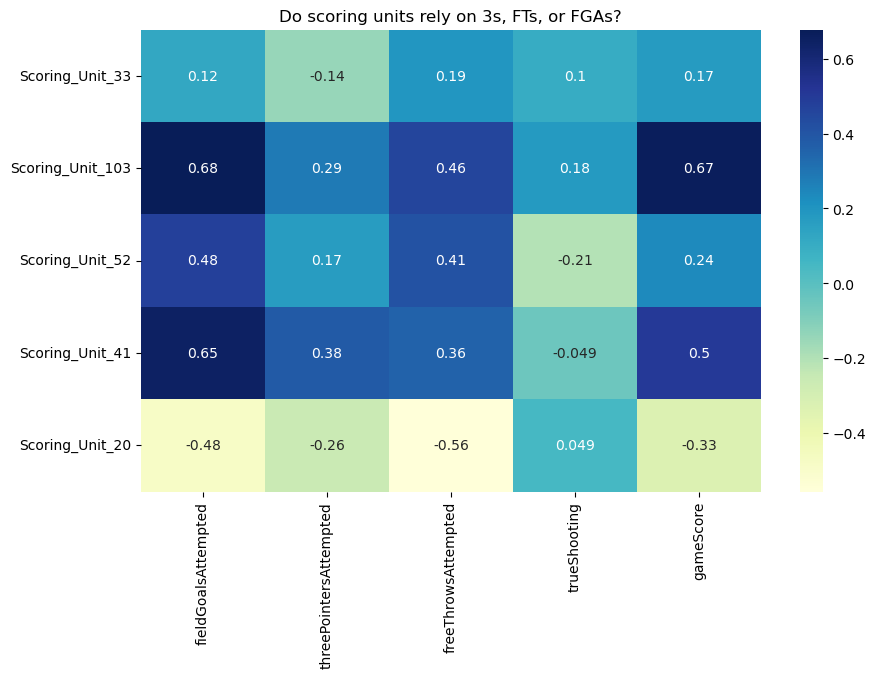

In [425]:
# hidden state data for these identified scoring units
feature_names = feature_cols + binary_cols
scoring_units_data = all_hidden_flat[:, top_scoring_units]

# create correlation matrix
scoring_corr_df = pd.DataFrame(scoring_units_data, columns=[f"Scoring_Unit_{i}" for i in top_scoring_units])
shot_features = ['fieldGoalsAttempted', 'threePointersAttempted', 'freeThrowsAttempted', 'trueShooting', 'gameScore']
shot_df = pd.DataFrame(all_features_flat, columns=feature_names)[shot_features]

# heatmap
scoring_feat_corr = pd.concat([scoring_corr_df, shot_df], axis=1).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(scoring_feat_corr.loc[[f"Scoring_Unit_{i}" for i in top_scoring_units], shot_features], 
            annot=True, cmap='YlGnBu')
plt.title("Do scoring units rely on 3s, FTs, or FGAs?")
plt.show()

Again, we see unit specialization, suggesting different units from our 'ball knowledge' hidden state are capturing different types of scorers

* Unit 33 is tracking FG and FT but not 3PA, suggesting focus on interior scoring
* Unit 103 is heavily weighted towards FGA and gameScore, suggesting it's tracking both overall scoring volume and efficiency
* Unit 52 again tracks FGA, FTA, 3PA, but does not care about trueShooting, suggesting it's our volume unit
* Unit 41 tracks 3PA more than other units in addition to general FGA and gameScore, suggesting it's our perimeter shooting tracker
* Unit 20 is anti-correlated with all measures except trueShooting, suggesting it's prioritizing low-volume but high-efficiency scorers

---

### 11) Generalizing our 'ball knowledge' model to previous eras
Now that we've verified that our model is learning about different play styles, player archetypes, and how they contribute to wins and scoring, we can apply this knowledge to previous eras.

In [457]:
# pull 90s data
prev_szn = utils.pull_season_data('1990-10-01', '2000-08-01')
filtered = utils.filter_season_data(prev_szn, 5, 25)
advanced = utils.add_advanced_stats(filtered)
prev_era = utils.clean_master_data(advanced)

modern_era = clean_data.copy()
prev_era = prev_era.copy()
# for games w/o ft's, 3's, etc.
prev_era['trueShooting'] = prev_era['trueShooting'].fillna(0)

In [458]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_style_vectors(era_df, scaler_obj, extractor_model):
    data = era_df[feature_cols].values
    
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # we need to scale our data WITHIN ERA so that values reflect tendencies relative to the rest of the league
    scaled_feats = scaler_obj.fit_transform(data)
    
    # combine w/ binary win and home columns
    inputs = np.hstack([scaled_feats, era_df[binary_cols].values])
    inputs = np.nan_to_num(inputs, nan=0.0)
    
    temp_df = era_df.reset_index(drop=True)
    sequences = []
    player_ids = []
    
    for pid, group in temp_df.groupby('personId'):
        sequences.append(inputs[group.index])
        player_ids.append(pid)
    
    X_pad = pad_sequences(sequences, maxlen=82, padding='pre', dtype='float32')
    hidden_states = extractor_model.predict(X_pad)
    final_states = np.nan_to_num(hidden_states[:, -1, :], nan=0.0)
    
    return final_states, player_ids

modern_vectors, modern_ids = get_style_vectors(modern_era, StandardScaler(), style_extractor)
era_vectors, era_ids = get_style_vectors(prev_era, StandardScaler(), style_extractor)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


---

### 12) what players from different eras are closest in our play-style features space?
* Within the 128-dimensional feature space we've created to define play styles, what current players are closest to historical greats?
* Mappings can be drawn from any era to any era by changing the season we train the RNN on and the vectors we pull above
* Examples of iconic 90s players are indicated below - SGA as the modern Jordan, Wemby as Hakeem, Jokic as Bird, etc.

In [460]:
from scipy.spatial.distance import euclidean

modern_name_map = modern_era.drop_duplicates('personId').set_index('personId')
era_name_map = prev_era.drop_duplicates('personId').set_index('personId')

def find_era_match(target_era_name):
    try:
        target_id = era_name_map[era_name_map['playerName'] == target_era_name].index[0]
        target_idx = era_ids.index(target_id)
    except:
        return "player not found in 90s subset"

    target_vec = era_vectors[target_idx]
    
    scores = []
    for i, m_id in enumerate(modern_ids):
        dist = euclidean(target_vec, modern_vectors[i])
        m_name = modern_name_map.loc[m_id, 'playerName']
        scores.append((m_name, dist))
    
    #sort by closest (lowest distance)
    scores.sort(key=lambda x: x[1])
    
    print(f"Top Stylistic Matches for {target_era_name} in 2025:")
    for name, dist in scores[:5]:
        print(f"- {name} (Distance: {dist:.4f})")

In [482]:
for player in ["Michael Jordan", "Hakeem Olajuwon", "Reggie Miller", "Isiah Thomas", "Larry Bird", "Charles Barkley", "David Robinson"]:
    find_era_match(player)
    print()

Top Stylistic Matches for Michael Jordan in 2025:
- Shai Gilgeous-Alexander (Distance: 2.0786)
- De'Aaron Fox (Distance: 2.1768)
- Jalen Williams (Distance: 2.3813)
- Devin Booker (Distance: 2.4252)
- Stephon Castle (Distance: 2.4346)

Top Stylistic Matches for Hakeem Olajuwon in 2025:
- Victor Wembanyama (Distance: 1.9623)
- Anthony Davis (Distance: 2.4437)
- Evan Mobley (Distance: 2.5099)
- Giannis Antetokounmpo (Distance: 2.7372)
- Alperen Sengun (Distance: 2.7859)

Top Stylistic Matches for Reggie Miller in 2025:
- Devin Booker (Distance: 1.5640)
- Shai Gilgeous-Alexander (Distance: 1.7263)
- Franz Wagner (Distance: 1.7298)
- Julius Randle (Distance: 1.7835)
- Tyrese Maxey (Distance: 1.8516)

Top Stylistic Matches for Isiah Thomas in 2025:
- James Harden (Distance: 1.3326)
- Trae Young (Distance: 1.4809)
- Keyonte George (Distance: 1.4890)
- Stephon Castle (Distance: 1.5141)
- De'Aaron Fox (Distance: 1.5633)

Top Stylistic Matches for Larry Bird in 2025:
- Nikola Jokic (Distance: 1

---

### 13) how have archetypes evolved from the 90s to today?
* pretty much how you'd expect! the biggest difference is in the explosion of three-point specialists

In [498]:
# assign modern players to clusters
modern_clusters = kmeans.predict(modern_vectors)

# assign 90s players to clusters
era_clusters = kmeans.predict(era_vectors)

# create comparison df
modern_dist = pd.Series(modern_clusters).value_counts(normalize=True).sort_index()
era_dist = pd.Series(era_clusters).value_counts(normalize=True).sort_index()

evolution_df = pd.DataFrame({
    '2025 Era (%)': modern_dist * 100,
    '90s Era (%)': era_dist * 100
}).fillna(0)

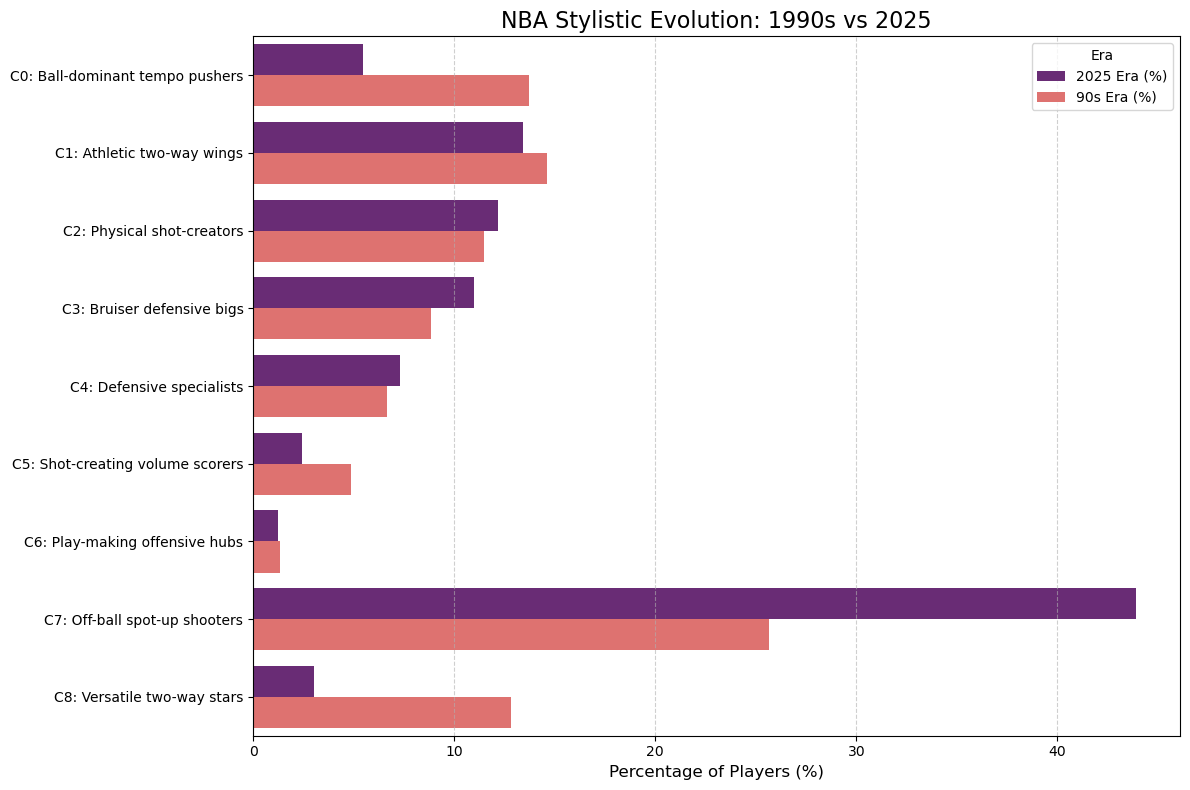

In [526]:
archetype_map = cluster_labels 
evolution_df['Archetype'] = evolution_df.index.map(lambda x: f"C{x}: {archetype_map.get(x, 'Unknown')}")

# melt for seaborn
plot_df = evolution_df.melt(id_vars='Archetype', var_name='Era', value_name='Percentage')

plt.figure(figsize=(12, 8))
sns.barplot(data=plot_df, x='Percentage', y='Archetype', hue='Era', palette='magma')

plt.title('NBA Stylistic Evolution: 1990s vs 2025', fontsize=16)
plt.xlabel('Percentage of Players (%)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()